In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

##### ERA5 Control/Ideal case

# 2-6 Compute anomalies

In [2]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

## 2. Extract domain

In [3]:
name_reanalysis = 'ERA5'
dataset_raw = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = dataset_raw.where((dataset_raw.lat>=lat0)&(dataset_raw.lat<=lat1)&\
                   (dataset_raw.lon>=lon0)&(dataset_raw.lon<=lon1),drop=True)

In [4]:
dataset_region.Z.data = dataset_region.Z.data/9.82 ### Divide by gravity to convert from m2/s2 to m

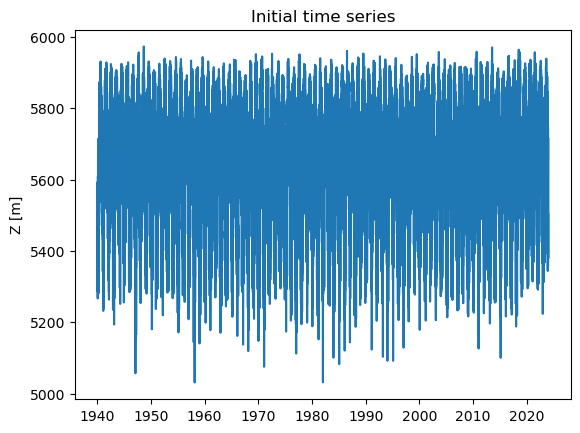

In [5]:
example_time_series = dataset_region.Z.sel(lat = 39,lon=-77+360)
plt.plot(example_time_series.time,example_time_series)
plt.title('Initial time series')
plt.ylabel('Z [m]')
plt.show()

## 3. Compute anomalies

In [6]:
def get_climatology_smoothed(dataset, var_name_xarray, window=60):
    # Subset dataset for the period 1981-2020
    dataset_clima = dataset
    # Remove leap day (Feb 29)
    dataset_clima = dataset_clima.isel(time=~((pd.to_datetime(dataset_clima.time).day == 29) &
                                              (pd.to_datetime(dataset_clima.time).month == 2)))
    
    # Get the day of year (DOY)
    doy = pd.to_datetime(dataset_clima.time).day_of_year
    climatology = []

    # Compute the daily mean for each day of the year
    for i in range(1, 366):
        daily_mean = dataset_clima.isel(time=doy == i)[var_name_xarray].mean('time')
        climatology.append(daily_mean)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = dataset[var_name_xarray].attrs
    attrs['File Author'] = 'Jhayron S. Pérez-Carrasquilla'
    
    climatology = xr.Dataset({
        f'{var_name_xarray}_climatology': (['day_of_year', 'lat', 'lon'], np.array(climatology)),
    }, 
    coords={
        'day_of_year': np.arange(1, 366),
        'lat': dataset.lat.values,
        'lon': dataset.lon.values,
    },
    attrs=attrs)

    climatology = climatology.transpose('day_of_year', 'lat', 'lon')
    print(climatology[f'{var_name_xarray}_climatology'].shape)
    # Stack climatology 3 times to handle edges
    climatology_extended = xr.concat([climatology, climatology, climatology], dim='day_of_year')

    # Adjust coordinates after stacking to represent a larger time span
    climatology_extended['day_of_year'] = np.arange(1, 365 * 3 + 1)

    # Apply rolling mean with a 60-day window for smoothing
    climatology_smoothed = climatology_extended.rolling(day_of_year=window, center=True, min_periods=1).mean()

    # Extract the middle portion, corresponding to the original 365 days
    climatology_smoothed = climatology_smoothed.isel(day_of_year=slice(365, 365 + 365))
    print(climatology_smoothed[f'{var_name_xarray}_climatology'].shape)
    # Reset 'day_of_year' coordinate to original range
    climatology_smoothed['day_of_year'] = np.arange(1, 366)

    return climatology_smoothed

def get_anomalies(dataset,var_name_xarray,climatology):
    anomalies = copy.deepcopy(dataset)
    for day in range(1,367):
        # print(day) 
        if day == 366:
            anomalies[var_name_xarray][{'time':(pd.to_datetime(dataset.time).day_of_year == day)}] = \
                (dataset[var_name_xarray].isel(time = (pd.to_datetime(dataset.time).day_of_year == day)) \
                - climatology[f'{var_name_xarray}_climatology'].sel(day_of_year = day-1))
        else:
            anomalies[var_name_xarray][{'time':(pd.to_datetime(dataset.time).day_of_year == day)}] = \
                (dataset[var_name_xarray].isel(time = (pd.to_datetime(dataset.time).day_of_year == day)) \
                - climatology[f'{var_name_xarray}_climatology'].sel(day_of_year = day))
    anomalies = anomalies.rename({var_name_xarray:f'{var_name_xarray}_anomalies'})
    # anomalies.to_netcdf(path_save_anomalies)
    return anomalies

In [7]:
clima = get_climatology_smoothed(dataset_region,'Z')

(365, 61, 151)
(365, 61, 151)


In [8]:
anoms = get_anomalies(dataset_region,'Z',clima)

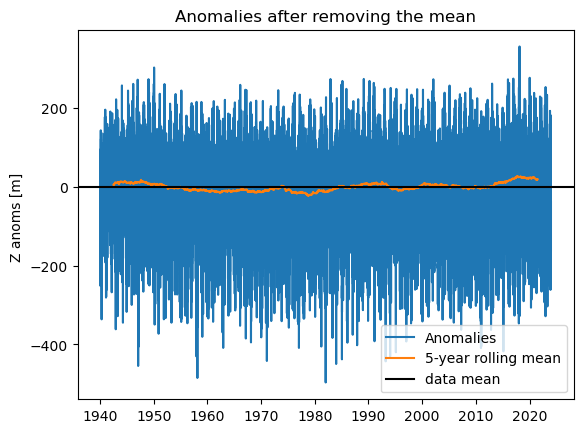

In [9]:
example_time_series = anoms.Z_anomalies.sel(lat = 39,lon=-77+360)
plt.plot(example_time_series.time,example_time_series,label='Anomalies')
plt.plot(example_time_series.time,example_time_series.rolling(time=5*365,center=True).mean(),label = '5-year rolling mean')
plt.axhline(np.mean(example_time_series),color='k',label='data mean')
plt.title('Anomalies after removing the mean')
plt.ylabel('Z anoms [m] ')
plt.legend()
plt.show()

## 4. Apply Fourier low-pass filter

In [10]:
def fourierfilter(dataarray,cutoff_period=10):
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(dataarray, axis=0)
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(dataarray.shape[0], d=1)  # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for low-pass filter (10 days)
    cutoff_period = 10
    
    # Create a mask to filter out high-frequency components (shorter than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set high-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anomalies = xr.DataArray(
        filtered_data,
        dims=dataarray.dims,
        coords=dataarray.coords,
        attrs=dataarray.attrs
    )
    return filtered_anomalies

In [11]:
anoms_filtered = fourierfilter(anoms.Z_anomalies)
anoms_filtered = anoms_filtered.to_dataset(name='Z_anomalies')

/glade/derecho/scratch/jhayron/tmp/ipykernel_187645/4262320059.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


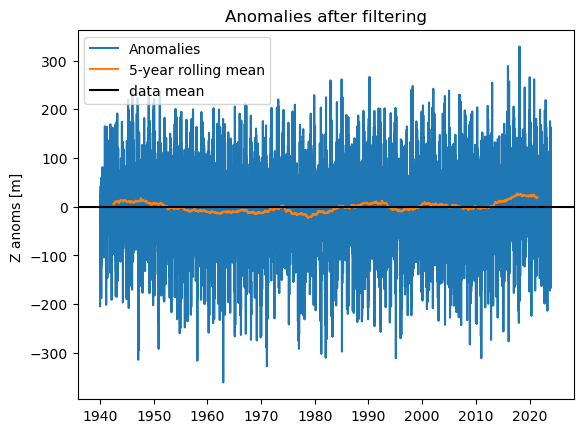

In [12]:
example_time_series = anoms_filtered.Z_anomalies.sel(lat = 39,lon=-77+360)
plt.plot(example_time_series.time,example_time_series,label='Anomalies')
plt.plot(example_time_series.time,example_time_series.rolling(time=5*365,center=True).mean(),label = '5-year rolling mean')
plt.axhline(np.mean(example_time_series),color='k',label='data mean')
plt.title('Anomalies after filtering')
plt.ylabel('Z anoms [m] ')
plt.legend()
plt.show()

## 5. Remove trends of the region (the trend of each DOY)

In [13]:
# Build a time series with the polynomials for each DOY

In [14]:
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True,min_periods=1).mean() # the smoothed data I use for trends

In [15]:
# Get average time series of the region

def get_weighted_area_average(dataarray):
    # Get latitudes
    lats = dataarray['lat']
    
    # Compute the cosine of the latitudes (in radians) for weighting
    cos_lat_weights = np.cos(np.deg2rad(lats))
    
    # Create a DataArray of the weights, expanded to match the dimensions of dataarray
    weights = xr.DataArray(
        cos_lat_weights, 
        dims=['lat'], 
        coords={'lat': lats}
    ).broadcast_like(dataarray)  # Broadcast weights to match lat/lon dimensions
    
    # Apply the weights and compute the mean across lat/lon
    weighted_mean = (dataarray * weights).sum(dim=['lat', 'lon']) / weights.sum(dim=['lat', 'lon'])
    
    return weighted_mean

In [16]:
lats = anoms_filtered.lat
lons = anoms_filtered.lon

In [17]:
anoms_detrended = copy.deepcopy(anoms_filtered)
from multiprocessing import Pool

# Function to process latitude and return results
def process_lat(lati):
    result = []
    print(lati, len(lats))
    for loni in range(len(lons)):
        serie_smooth_temp = anoms_smooth.sel(lat=lats[lati], lon=lons[loni]).Z_anomalies
        serie_anoms_temp = anoms_filtered.sel(lat=lats[lati], lon=lons[loni]).Z_anomalies
        full_curve = copy.deepcopy(serie_smooth_temp)
        full_curve.data = np.zeros(len(full_curve))
        
        for label, ens_group in serie_smooth_temp.groupby('time.dayofyear'):  # Iterate through every day of the year
            npoly = 3
            params_curve = polynomial.polyfit(np.arange(0, ens_group.shape[0]), ens_group, npoly)  # Fit a polynomial for the trend of each DOY
            curve = polynomial.polyval(np.arange(0, ens_group.shape[0]), params_curve, tensor=True)
            # Center curve in zero
            full_curve.loc[{'time': ens_group.time}] = curve

        serie_anoms_temp_detrended = serie_anoms_temp - full_curve
        result.append((lats[lati], lons[loni], serie_anoms_temp_detrended))
    return result

# Parallelize over latitude indices and collect results
results = []
with Pool(processes=250) as pool:  # Adjust the number of processes to match your system
    results = pool.map(process_lat, range(len(lats)))

# Update `anoms_detrended` in the main process
for res in results:
    for lat, lon, detrended in res:
        anoms_detrended.Z_anomalies.loc[{'lat': lat, 'lon': lon}] = detrended

1056237489101211  131415  16 1719  20182122  2324   256126  27 6161 29303161 323361 34 61356136  39 37 38404161424361  61444661476148 49
455051 6161526155 5453

56615759 58 60 
61  61
61 

  6161 61 61   
  
6161
  
 
 61    
61

  61   
  6161  61
6161

616161

61
61
6161616161

61616161
61616161
6161
6161616161

61
61




























28 61


Text(0, 0.5, 'Z [m]')

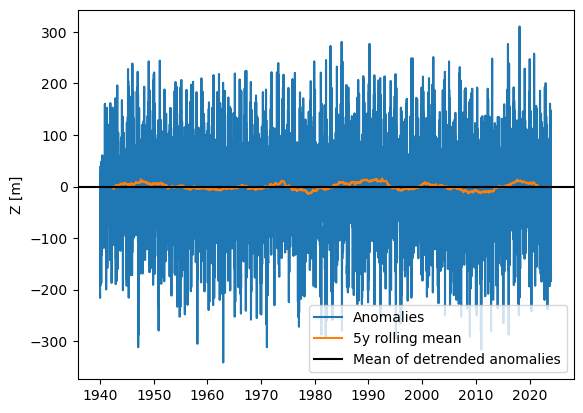

In [18]:
example_time_series = anoms_detrended.Z_anomalies.sel(lat = 39,lon=-77+360)

plt.plot(example_time_series.time,example_time_series,label='Anomalies')
# plt.plot(full_curve.time,full_curve)
plt.plot(example_time_series.time,example_time_series.rolling(time=5*365,center=True).mean(),label='5y rolling mean')
# plt.plot(mean_series.time,mean_series,color='k',alpha=0.4)
plt.axhline(np.mean(example_time_series),color='k',label='Mean of detrended anomalies')
plt.legend()
plt.ylabel('Z [m]')

## 6. Standardize anomalies

In [19]:
def get_climatology_std_smoothed(dataset, var_name_xarray, window=60):
    # Remove leap day (Feb 29)
    dataset_clima = dataset.isel(time = ~((pd.to_datetime(dataset.time).day == 29) & 
                                          (pd.to_datetime(dataset.time).month == 2)))
    
    # Get the day of year (DOY)
    doy = pd.to_datetime(dataset_clima.time).day_of_year
    climatology = []

    # Compute the daily standard deviation for each day of the year
    for i in range(1, 366):
        array_temp = dataset_clima.isel(time=doy == i)[var_name_xarray]
        std = np.nanstd(array_temp, axis=0)
        std[std == 0] = np.nan
        climatology.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = dataset[var_name_xarray].attrs
    attrs['File Author'] = 'Jhayron S. Pérez-Carrasquilla'
    
    climatology = xr.Dataset({
        f'{var_name_xarray}_climatology_std': (['day_of_year', 'lat', 'lon'], np.array(climatology)),
    }, 
    coords={
        'day_of_year': np.arange(1, 366),
        'lat': dataset.lat.values,
        'lon': dataset.lon.values,
    },
    attrs=attrs)

    climatology = climatology.transpose('day_of_year', 'lat', 'lon')
    # print(climatology)
    # Stack climatology 3 times to handle edges
    climatology_extended = xr.concat([climatology, climatology, climatology], dim='day_of_year')

    # Adjust coordinates after stacking to represent a larger time span
    climatology_extended['day_of_year'] = np.arange(1, 365 * 3+1)

    # Apply rolling mean with a 60-day window for smoothing
    climatology_smoothed = climatology_extended.rolling(day_of_year=window, center=True, min_periods=1).mean()

    # Extract the middle portion, corresponding to the original 365 days
    climatology_smoothed = climatology_smoothed.isel(day_of_year=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climatology_smoothed['day_of_year'] = np.arange(1, 366)

    return climatology_smoothed


def standardize_anomalies(anomalies,var_name_xarray,climatology_std):
    std_anomalies = copy.deepcopy(anomalies)
    for day in range(1,367):
        # print(day) 
        if day == 366:
            std_anomalies[var_name_xarray][{'time':(pd.to_datetime(anomalies.time).day_of_year == day)}] = \
                (anomalies[var_name_xarray].isel(time = (pd.to_datetime(anomalies.time).day_of_year == day)) \
                / climatology_std[f'{var_name_xarray}_climatology_std'].sel(day_of_year = day-1))
        else:
            std_anomalies[var_name_xarray][{'time':(pd.to_datetime(anomalies.time).day_of_year == day)}] = \
                (anomalies[var_name_xarray].isel(time = (pd.to_datetime(anomalies.time).day_of_year == day)) \
                / climatology_std[f'{var_name_xarray}_climatology_std'].sel(day_of_year = day))
    # std_anomalies = std_anomalies.rename({var_name_xarray:f'{var_name_xarray}_anomalies'})
    # std_anomalies.to_netcdf(path_save_anomalies)
    return std_anomalies

In [20]:
clima_std = get_climatology_std_smoothed(anoms_detrended,'Z_anomalies')

In [21]:
anoms_standardized = standardize_anomalies(anoms_detrended,'Z_anomalies',clima_std)

Text(0.5, 1.0, 'Final detrended standardized anomalies')

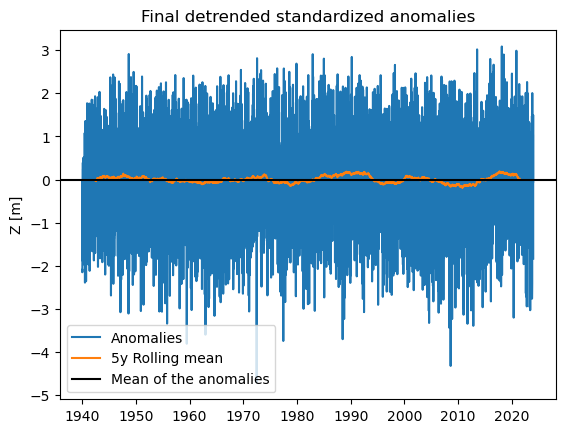

In [22]:
example_time_series = anoms_standardized.Z_anomalies.sel(lat = 39,lon=-77+360)

plt.plot(example_time_series.time,example_time_series,label='Anomalies')
# plt.plot(full_curve.time,full_curve)
plt.plot(example_time_series.time,example_time_series.rolling(time=5*365,center=True).mean(),label='5y Rolling mean')
# plt.plot(mean_series.time,mean_series,color='k',alpha=0.4)
plt.axhline(np.mean(example_time_series),color='k',label='Mean of the anomalies')
plt.legend()
plt.ylabel('Z [m]')
plt.title('Final detrended standardized anomalies')

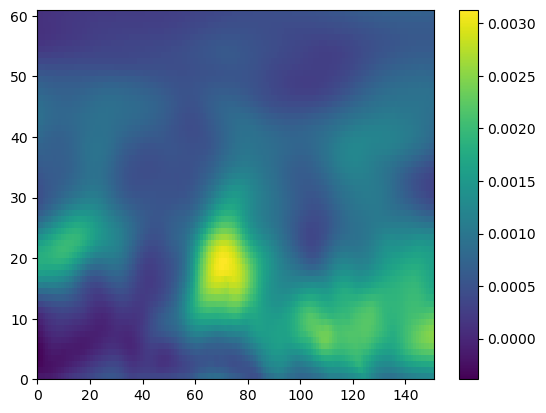

In [23]:
plt.pcolormesh(anoms_standardized.mean('time').Z_anomalies)
plt.colorbar()

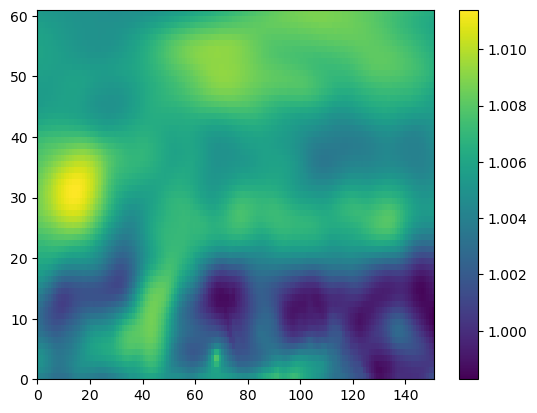

In [24]:
plt.pcolormesh(anoms_standardized.std('time').Z_anomalies)
plt.colorbar()

In [25]:
anoms_standardized.to_netcdf('/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/AnomsExps/Z_anomalies_Exp6.nc')

# 7-9 Compute PCs and WRs

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math

In [27]:
anoms_standardized = xr.open_dataset('/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/AnomsExps/Z_anomalies_Exp6.nc')

## 7. Compute PCs

In [28]:
var_name = 'Z_anomalies'
z500_anoms_flattened = anoms_standardized.stack(flat=('lat','lon')).transpose('time','flat')[var_name]

In [29]:
z500_anoms_flattened_training = copy.deepcopy(z500_anoms_flattened)

In [30]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(z500_anoms_flattened_training)

# transform era5 data with pca
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened_training)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')

import joblib

filename = r'/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/AnomsExps/PCsExps/PCA_Exp6.mdl'
joblib.dump(pca_obj,filename)

filename = r'/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/AnomsExps/PCsExps/PCA_Exp6.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

Variance explained: [13.98304571 11.27098456  9.42176171  6.25081446  5.9413667   5.50361641
  5.02836725  4.01101449  3.91026184  2.98197904  2.89500254  2.6366126 ]
Cumulative sum of variance explained for EOF1 and EOF2: [13.98304571 25.25403027 34.67579198 40.92660644 46.86797313 52.37158954
 57.3999568  61.41097129 65.32123312 68.30321217 71.1982147  73.83482731]


In [31]:
import joblib
pca_obj = joblib.load(r'/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/AnomsExps/PCsExps/PCA_Exp6.mdl')
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened_training)

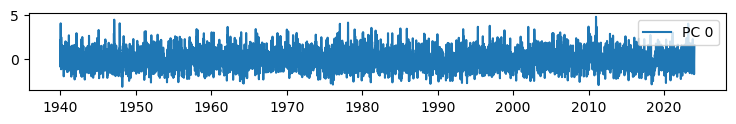

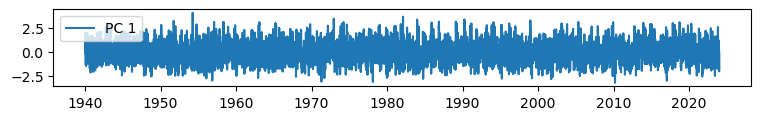

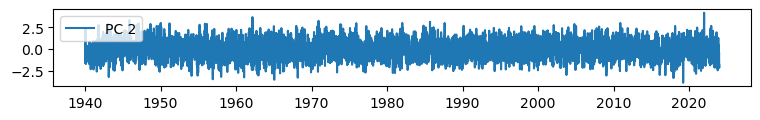

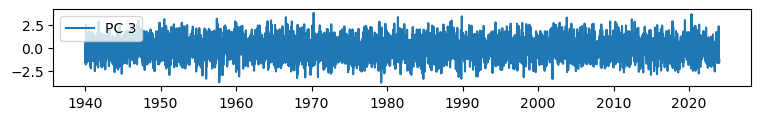

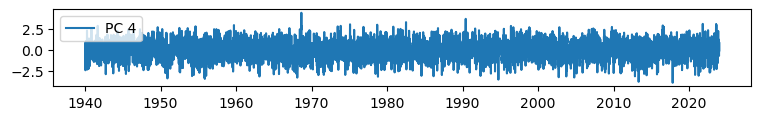

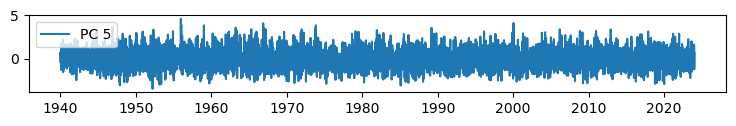

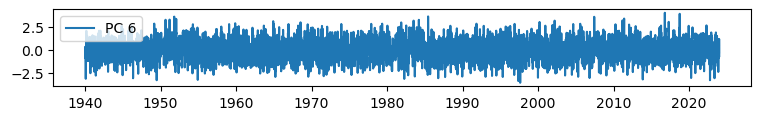

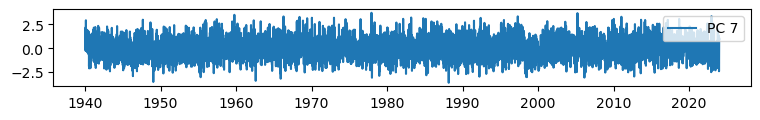

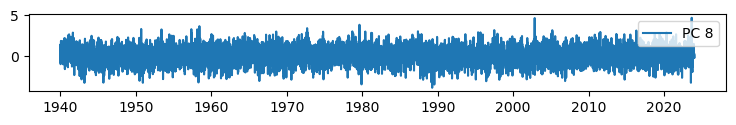

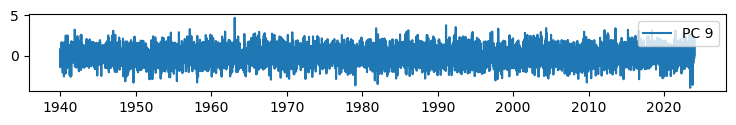

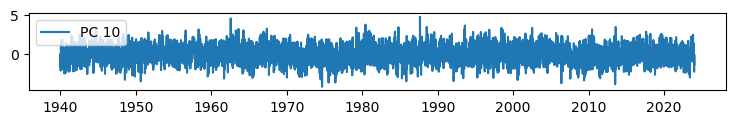

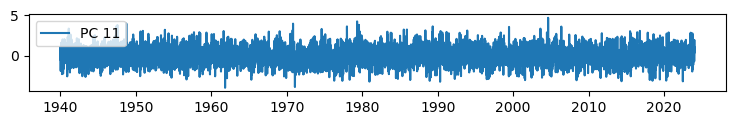

In [32]:
for i in range(12):
    plt.figure(figsize=(9,1))
    plt.plot(anoms_standardized.time,z500_anoms_transformed[:,i],
             label=f'PC {i}')
    plt.legend()
    plt.show()
    plt.close()

## 8. Find optimal number of clusters

In [33]:
from multiprocessing import Pool
from scipy.optimize import linear_sum_assignment

def run_kmeans(params_temp): ## function to run the kmeans algorithm with one specific seed
    data, seed, k, n_init_internal = params_temp
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init_internal, random_state=seed)
    kmeans.fit(data)
    return {
        "inertia": kmeans.inertia_,
        "cluster_centers": kmeans.cluster_centers_,
        "labels": kmeans.labels_
    }

In [34]:
data4clustering = copy.deepcopy(z500_anoms_transformed)
random_seed = 0
n_init = 500

In [35]:
dic_results_best_k = {}
dic_results_best_k['db_index'] = []
dic_results_best_k['max_intercluster_corr'] = []
dic_results_best_k['centroids'] = []
dic_results_best_k['labels'] = []

dbis = []
for k in range(2,11):
    print(k)
    results_kmeans = run_kmeans((data4clustering,random_seed,k,n_init))
    ## Compute the Davies-Bouldin Score 
    dbi = davies_bouldin_score(data4clustering, results_kmeans['labels'])

    ## Compute the maximum intercluster correlation
    correlation_matrix = np.corrcoef(results_kmeans['cluster_centers'])
    np.fill_diagonal(correlation_matrix, np.nan)
    max_intercluster_corr = np.nanmax(correlation_matrix)
    
    dic_results_best_k['db_index'].append(dbi)
    dic_results_best_k['max_intercluster_corr'].append(max_intercluster_corr)
    dic_results_best_k['centroids'].append(results_kmeans['cluster_centers'])
    dic_results_best_k['labels'].append(results_kmeans['labels'])

2
3
4
5
6
7
8
9
10


In [36]:
np.save('dic_results_best_k_Exp6.npy',dic_results_best_k)

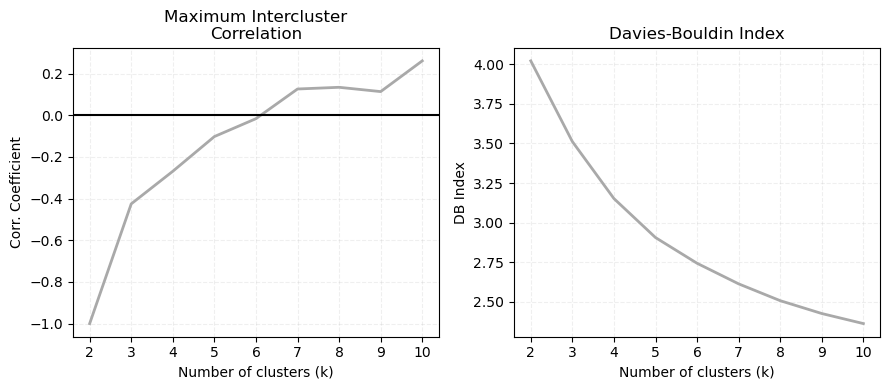

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].plot(np.arange(2,11),dic_results_best_k['max_intercluster_corr'],color='darkgray',lw=2)
axes[0].axhline(0,color='k')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Corr. Coefficient')
axes[0].set_title('Maximum Intercluster\nCorrelation')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')

axes[1].plot(np.arange(2,11),dic_results_best_k['db_index'],color='darkgray',lw=2)
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_ylabel('DB Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')

plt.tight_layout()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

## 9. Plot composites for best k

In [38]:
maxcorrs = np.array(copy.deepcopy(dic_results_best_k['max_intercluster_corr']))
maxcorrs[maxcorrs>0] = np.nan
best_k = np.nanargmax(maxcorrs)+2

In [39]:
clusters_centers = copy.deepcopy(dic_results_best_k['centroids'][best_k-2])
labels = copy.deepcopy(dic_results_best_k['labels'][best_k-2])

In [40]:
## Add climatology cluster
cluster_centers = np.vstack([clusters_centers,np.zeros(12)])
distances = euclidean_distances(cluster_centers, z500_anoms_transformed)
new_labels = distances.argmin(axis=0)
df_labels = pd.DataFrame(new_labels,index=anoms_standardized.time)

In [41]:
df_labels.columns=['WR']

In [42]:
df_labels['distances'] = distances.min(axis=0)

In [43]:
def get_average_fields_for_centroids(dataarray,labels):
    wrs = np.unique(labels['WR'])
    avgs = []
    for wr in wrs:
        df_wr = labels[labels['WR']==wr]
        arr_selection = dataarray.sel(time=df_wr.index)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return xr.concat(avgs,dim='WR')

In [44]:
def plot_multiple_maps(da,freqs_labels,regioncoords,names = None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da.WR)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(da.WR.values)-1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-2
        maxi=2
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anomalies.values, 
                           levels=bounds, vmin=mini, vmax=maxi,
                            cmap='coolwarm', transform=ccrs.PlateCarree(),extend='both')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.3, -0.05, 0.4, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if path_save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=100)
        plt.close('all')

In [45]:
frequencies_percent = df_labels['WR'].value_counts(normalize=True) * 100
frequencies_percent = frequencies_percent.sort_index().values
region = [180, 330, 20, 80]

In [46]:
# compute composites for each cluster
composites = get_average_fields_for_centroids(anoms_standardized,df_labels)

In [47]:
plot_multiple_maps(composites,frequencies_percent,
                   region,names=None, path_save=f'Composites_Exp6.png')

# Old/trash but maybe useful

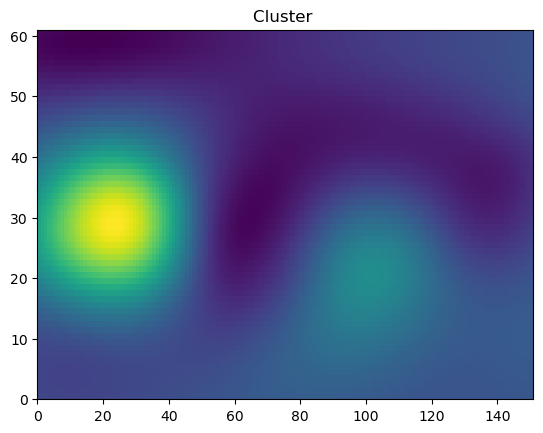

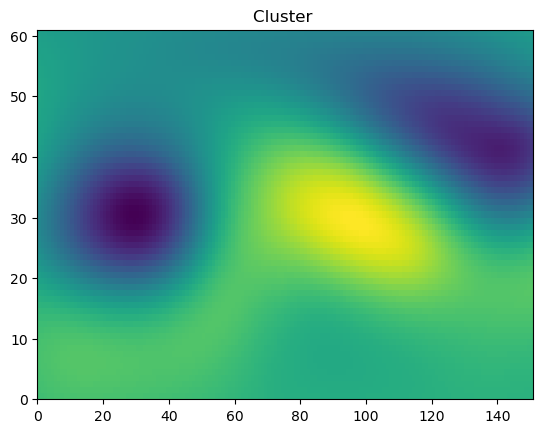

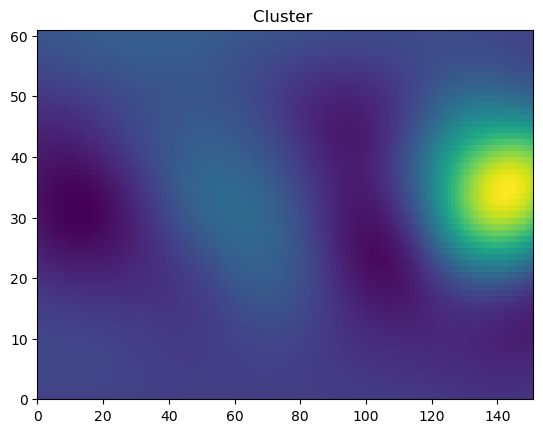

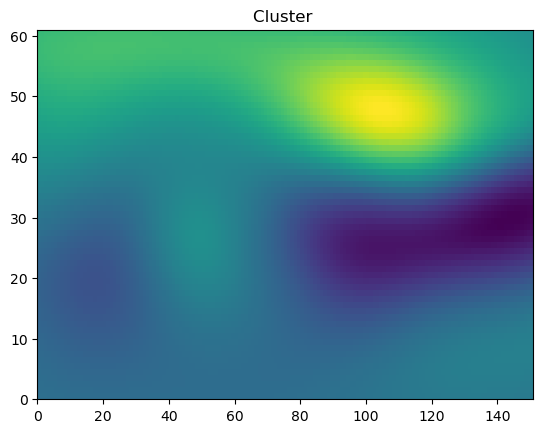

In [115]:
## Some speed tests:
results_example = run_kmeans((z500_anoms_transformed,55,4,10))

def convert_from_pcs_to_spatial(a,original_piece_of_data):
    # print(original_piece_of_data)
    original_piece_of_data.data = pca_obj.inverse_transform(a)
    # print(original_piece_of_data)
    return original_piece_of_data.unstack('flat')
    
for ki in range(4):
    example_cluster = convert_from_pcs_to_spatial(results_example['cluster_centers'][ki],
                                        copy.deepcopy(z500_anoms_flattened_training.isel(time=0)))
    plt.pcolormesh(example_cluster)
    plt.title('Cluster ')
    plt.show()

In [121]:
### Test to see the effect of internal n_init in classifiability
k=4
n_init=50
for n_init_internal in [1,3,5,10,25,50,100]:
    similarity_test, classifiability_test, _, _=\
                            compute_classifiability(z500_anoms_transformed,
                            k=k,
                            n_init=n_init,
                            pca_obj=pca_obj,
                            n_processes_multiprocessing=50,
                            n_init_internal=n_init_internal)
    print(n_init_internal,classifiability_test)

1 0.32461909263001604
3 0.46775737385020577
5 0.6045572336493179
10 0.8333723064153977
25 0.9763054345004587
50 0.9796099237893147
100 0.9809433095572275


In [122]:
### Test to see the effect of internal n_init in classifiability
k=4
n_init=50
for n_init_internal in [200,500]:
    similarity_test, classifiability_test, _, _=\
                            compute_classifiability(z500_anoms_transformed,
                            k=k,
                            n_init=n_init,
                            pca_obj=pca_obj,
                            n_processes_multiprocessing=50,
                            n_init_internal=n_init_internal)
    print(n_init_internal,classifiability_test)

200 0.9813401238145636
500 0.9862091615226274


In [117]:
def compute_classifiability(data4clustering, k, n_init, pca_obj,n_processes_multiprocessing,n_init_internal=1):
    params = [(data4clustering, seed_i,k,n_init_internal) for seed_i in range(n_init)]
    # Create a pool of workers and run KMeans in parallel
    with Pool(processes=n_processes_multiprocessing) as pool: ### SPECIFY NUMBER OF PROCESSES
        results_kmeans = pool.map(run_kmeans, params)
    
    ## compute classifiability according to L23 and MV95
    ## (https://journals.ametsoc.org/view/journals/clim/36/20/JCLI-D-23-0214.1.xml#bib39)
    ## 
    centroids_inits = []
    for init in range(n_init):
        centroids_inits.append(results_kmeans[init]['cluster_centers'])
    centroids_inits = np.array(centroids_inits)
    
    min_corrs = []
    for init0 in range(n_init):
        min_corrs_temp = []
        for init1 in range(n_init):
            if init0==init1:
                continue
            else:
                # corr_matrix = np.corrcoef(centroids_inits[init0],centroids_inits[init1])[:k,-k:]
                corr_matrix = np.corrcoef(pca_obj.inverse_transform(centroids_inits[init0]),
                                          pca_obj.inverse_transform(centroids_inits[init1]))[:k,-k:]
                cost_matrix = -corr_matrix
                ## This line assigns each cluster from group 1 to the most similar cluster from group zero
                ## solving the assignment problem using the Jonker-Volgenant algorithm
                row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
                matched_clusters = list(zip(row_ind, col_ind))
                matched_correlations = corr_matrix[row_ind, col_ind]
                # matched_correlations = corr_matrix.max(axis=0)
                min_corr = np.min(matched_correlations)
                min_corrs_temp.append(min_corr)
    
        min_corrs.append(min_corrs_temp)
    
    similarity = np.array(min_corrs) ## This is the similarity
    classifiability = np.mean(min_corrs)
    # 1. Choose the reference partition (with the maximum average similarity value)
    pos_reference_partition = similarity.mean(axis=1).argmax()
    ref_centroids = centroids_inits[pos_reference_partition]
    return similarity, classifiability, ref_centroids, pos_reference_partition

In [69]:
def compute_reproducibility(data4clustering,ref_centroids_temp,
                            k,n_subsets,n_init,pca_obj,n_processes_multiprocessing):
    ## Draw n_subsets random half-length subsamples from the atmospheric data and compute the reproducibility index
    ## according to MV95

    reproducibility_subsets = []
    classifiability_subsets = []
    for seed_temp in range(n_subsets):
        # print(seed_temp)
        np.random.seed(seed_temp)
        # Select half of the data randomly
        random_indices = np.random.choice(np.arange(len(data4clustering)),size=int(len(data4clustering)/2),replace=False)
        data_subset_temp = data4clustering[random_indices]
        ## Compute similarity on the subset to extract the reference/best clustering
        similarity_temp_subset, classifiability_temp_subset, \
            ref_centroids_temp_subset, seed_ref_temp_subset = compute_classifiability(
                               data_subset_temp,
                               k=k,
                               n_init=n_init,
                               pca_obj=pca_obj,
                               n_processes_multiprocessing=n_processes_multiprocessing)
        ## Correlation matrix between the clusters of  subset and the full set
        corr_matrix = np.corrcoef(pca_obj.inverse_transform(ref_centroids_temp),
                                  pca_obj.inverse_transform(ref_centroids_temp_subset))[:k,-k:]
        cost_matrix = -corr_matrix
        ## This line assigns each cluster from group 1 to the most similar cluster from group zero
        ## solving the assignment problem using the Jonker-Volgenant algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
        matched_clusters = list(zip(row_ind, col_ind))
        matched_correlations = corr_matrix[row_ind, col_ind]
        reproducibility_subsets.append(matched_correlations)
        classifiability_subsets.append(classifiability_temp_subset)

    return np.array(reproducibility_subsets), np.array(classifiability_subsets)

In [70]:
n_init = 50  #50 in MV95 and 1000 L23
n_processes_multiprocessing = 50
n_subsets_reproducibility = 5 #100 MV95 1000 L23

In [71]:
dic_results_best_k = {}
dic_results_best_k['similarity'] = []
dic_results_best_k['classifiability'] = []
dic_results_best_k['ref_centroids'] = []
dic_results_best_k['seed_ref_centroids'] = []
dic_results_best_k['reproducibility_subsets'] = []
dic_results_best_k['reproducibility'] = []
dic_results_best_k['classifiability_subsets'] = []
dic_results_best_k['db_index'] = []
dic_results_best_k['max_intercluster_corr'] = []

print('k','classifiability','reproducibility','dbi','max_intercluster_corr')

# for k in range(2,11):
for k in [3]:
    ## Compute classifiability and find the best clustering
    similarity_temp, classifiability_temp, ref_centroids_temp, seed_ref_temp = compute_classifiability(
                           copy.deepcopy(z500_anoms_transformed),
                           k=k,
                           n_init=n_init,
                           pca_obj=pca_obj,
                           n_processes_multiprocessing=n_processes_multiprocessing)
    # run_kmeans((copy.deepcopy(z500_anoms_transformed),seed_ref_temp,5)) If I need to re-run the reference partitioning
    
    ## Compute reproducibility and classifiability for each subset of data
    reproducibility_subsets_temp, classifiability_subsets_temp = compute_reproducibility(
                            copy.deepcopy(z500_anoms_transformed),
                            ref_centroids_temp,
                            k,
                            n_subsets=n_subsets_reproducibility,
                            n_init=n_init,
                            pca_obj=pca_obj,
                            n_processes_multiprocessing=n_processes_multiprocessing)
    reproducibility_temp = reproducibility_subsets_temp.mean(axis=0)
    
    results_kmeans_best_model = run_kmeans((copy.deepcopy(z500_anoms_transformed),seed_ref_temp,k))
    
    ## Compute the Davies-Bouldin Score 
    dbi = davies_bouldin_score(copy.deepcopy(z500_anoms_transformed), results_kmeans_best_model['labels'])

    ## Compute the maximum intercluster correlation
    correlation_matrix = np.corrcoef(results_kmeans_best_model['cluster_centers'])
    np.fill_diagonal(correlation_matrix, np.nan)
    max_intercluster_corr = np.nanmax(correlation_matrix)

    dic_results_best_k['similarity'].append(similarity_temp)
    dic_results_best_k['classifiability'].append(classifiability_temp)
    dic_results_best_k['ref_centroids'].append(ref_centroids_temp)
    dic_results_best_k['seed_ref_centroids'].append(seed_ref_temp)
    dic_results_best_k['reproducibility_subsets'].append(reproducibility_subsets_temp)
    dic_results_best_k['reproducibility'].append(reproducibility_temp)
    dic_results_best_k['classifiability_subsets'].append(classifiability_subsets_temp)
    dic_results_best_k['db_index'].append(dbi)
    dic_results_best_k['max_intercluster_corr'].append(max_intercluster_corr)
    print(k,classifiability_temp,reproducibility_temp,dbi,max_intercluster_corr)

k classifiability reproducibility dbi max_intercluster_corr
60
13255

76
78
118
8531

80
75
49
111
6072

38
8241

120
3972
114

64
13069

69
63
5094
76

80
93
72
174
7884

107
67
63
93
54
67
33
100170

63
86
89
122
63
41
106
96
44
82
61
32
95
107
55
6747

116
8157

6055

98106

65
66
101
63585972



963784
101


9571

109581218031




8084

126
69
13988
107

115136

103
154
10655

59



KeyboardInterrupt



In [45]:
dic_results_best_k['similarity'] = np.array(dic_results_best_k['similarity'])
dic_results_best_k['classifiability'] = np.array(dic_results_best_k['classifiability'])
dic_results_best_k['classifiability_subsets'] = np.array(dic_results_best_k['classifiability_subsets'])
dic_results_best_k['seed_ref_centroids'] = np.array(dic_results_best_k['seed_ref_centroids'])
dic_results_best_k['db_index'] = np.array(dic_results_best_k['db_index'])
dic_results_best_k['max_intercluster_corr'] = np.array(dic_results_best_k['max_intercluster_corr'])

In [46]:
lower_bound_subsets_class = dic_results_best_k['classifiability_subsets'].min(axis=1)
upper_bound_subsets_class = dic_results_best_k['classifiability_subsets'].max(axis=1)

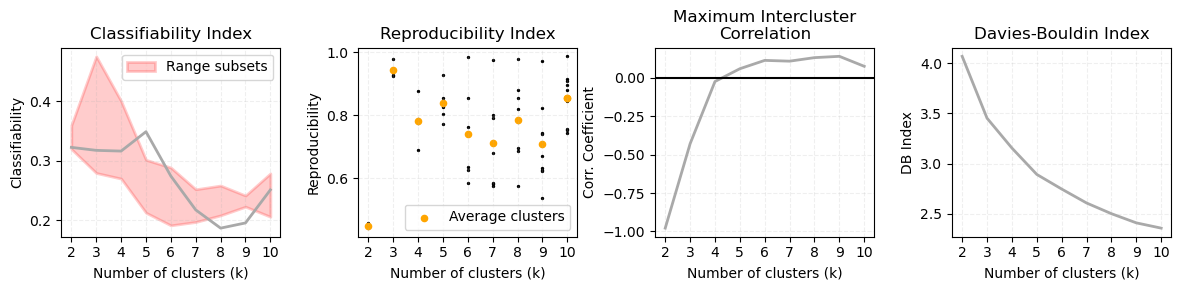

In [47]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))

axes[0].plot(np.arange(2,11),dic_results_best_k['classifiability'],color='darkgray',lw=2)
axes[0].fill_between(np.arange(2,11),lower_bound_subsets_class,upper_bound_subsets_class,
                     color='red',lw=2,alpha=0.2,label='Range subsets')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_title('Classifiability Index')
axes[0].set_ylabel('Classifiability')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')
axes[0].legend()

for k in range(2,11):
    axes[1].scatter(np.repeat(k,k),
             dic_results_best_k['reproducibility'][k-2],color='k',s=2)
    axes[1].scatter(k,
             np.mean(dic_results_best_k['reproducibility'][k-2]),
                    color='orange',s=20)
axes[1].scatter(k,
         np.mean(dic_results_best_k['reproducibility'][k-2]),
                color='orange',s=20,label='Average clusters')
    # axes[1].axhline(0,color='k')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Reproducibility')
axes[1].set_title('Reproducibility Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')
axes[1].legend()

axes[2].plot(np.arange(2,11),dic_results_best_k['max_intercluster_corr'],color='darkgray',lw=2)
axes[2].axhline(0,color='k')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Corr. Coefficient')
axes[2].set_title('Maximum Intercluster\nCorrelation')
axes[2].set_xticks(np.arange(2,11))
axes[2].grid(alpha=0.2,ls='--')

axes[3].plot(np.arange(2,11),dic_results_best_k['db_index'],color='darkgray',lw=2)
axes[3].set_xlabel('Number of clusters (k)')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_ylabel('DB Index')
axes[3].set_xticks(np.arange(2,11))
axes[3].grid(alpha=0.2,ls='--')

plt.tight_layout()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

In [48]:
### Now we have to compute the classifiability index for n_synth autoregressive models and each k

In [49]:
from scipy.stats import multivariate_normal

In [50]:
# Assume X has shape (n_times, 12)
# n_times: number of time steps, 12: number of PCs

# Function to compute lag-0 covariance (C0)
def compute_covariance(data):
    """
    Computes the covariance matrix (C0) of the given data.
    data: numpy array of shape (n_times, num_pcs).
    """
    return np.cov(data, rowvar=False)  # Covariance along the PCs (columns)

# Function to compute lag-1 covariance (C1)
def compute_lagged_covariance(data):
    """
    Computes the lag-1 covariance matrix (C1) of the given data.
    data: numpy array of shape (n_times, num_pcs).
    """
    data_t = data[:-1, :]  # Time step t
    data_t1 = data[1:, :]  # Time step t+1
    return np.cov(data_t.T, data_t1.T)[:data.shape[1], data.shape[1]:]

In [51]:
# Function to generate a single synthetic time series
def generate_markov_process(A, Q, C0, steps, num_pcs, seed_temp):
    """
    Generate a synthetic time series following a first-order Markov process.
    """
    np.random.seed(seed_temp)
    # Initialize with random values from the stationary distribution
    X = np.random.multivariate_normal(mean=np.zeros(num_pcs), cov=C0)
    time_series = [X]
    
    for _ in range(steps - 1):
        # Generate noise
        noise = np.random.multivariate_normal(mean=np.zeros(num_pcs), cov=Q)
        # Compute next step
        X = np.dot(A, X) + noise  # Shape: (12,)
        time_series.append(X)
    
    return np.array(time_series)  # Shape: (steps, 12)

# Wrapper function for multiprocessing
def generate_one_variation(args):
    """
    Wrapper function to generate a single time series for multiprocessing.
    """
    A, Q, C0, steps, num_pcs, seed_temp = args
    return generate_markov_process(A, Q, C0, steps, num_pcs, seed_temp)

# Multiprocessing function to generate multiple variations
def generate_multiple_variations_multiprocessing(A, Q, C0, steps, num_pcs, n_variations,ncores):
    """
    Generate multiple variations using multiprocessing.
    """
    # Create arguments for each process
    args = [(A, Q, C0, steps, num_pcs, seed_temp) for seed_temp in range(n_variations)]
    
    # Use all available CPU cores
    n_cores = ncores ## SPECIFY # OF CORES
    with Pool(n_cores) as pool:
        all_variations = pool.map(generate_one_variation, args)
    
    return np.array(all_variations)  # Shape: (n_variations, steps, num_pcs)

In [52]:
np.random.seed(0)
X = copy.deepcopy(z500_anoms_transformed)
n_times = len(X)  # Number of time steps per time series
num_pcs = X.shape[1]    # Number of PCs
n_variations = 5  # Number of random variations for the AR synthetic models: 100 in MV95 and L23

In [53]:
# Step 1: Compute Covariance Matrices
C0 = compute_covariance(X)  # Lag-0 covariance, shape: (12, 12)
C1 = compute_lagged_covariance(X)  # Lag-1 covariance, shape: (12, 12)

# Step 2: Compute Transition Matrix (A). Since X(t+1) = A.X(t) + w(t)), with w being the noise
# The diagonal of A is the lag-1 autocorrelation of each PC (non-noisy component) with itself
A = np.dot(C1, np.linalg.inv(C0))  # Shape: (12, 12)

# Step 3: Compute Noise Covariance (Q).
#each entry  Q{ij}  represents the covariance between the noise components  w_{i,t}  and  w_{j,t} 
#The noise vector drawn from a muktivariate normal distribution with mean zero and covariance Q
Q = C0 - np.dot(A, C1.T)  # Shape: (12, 12)

# Step 4: Generate synthetic data
all_synthetic_data = generate_multiple_variations_multiprocessing(A, Q, C0, n_times, num_pcs, 
                                                                  n_variations,n_processes_multiprocessing)
print(all_synthetic_data.shape)

(5, 30681, 12)


In [54]:
## Sanity check: The diagonal of A, Q, and C0 with the synthetic data must be similar to those computed
## with the original data

X_synthetic = all_synthetic_data[3]
C0_synthetic = compute_covariance(X_synthetic)  # Lag-0 covariance, shape: (12, 12)
C1_synthetic = compute_lagged_covariance(X_synthetic)  # Lag-1 covariance, shape: (12, 12)
A_synthetic = np.dot(C1_synthetic, np.linalg.inv(C0_synthetic))  # Shape: (12, 12)
Q_synthetic = C0 - np.dot(A_synthetic, C1_synthetic.T)  # Shape: (12, 12)

print('Diagonals: ')
print('A original:',A.diagonal())
print('A synthetic:',A_synthetic.diagonal())
print('Q original:',Q.diagonal())
print('Q synthetic:',Q_synthetic.diagonal())
print('C1 original:',C1.diagonal())
print('C1 synthetic:',C1_synthetic.diagonal())

#Conclusion--courtesy of ChatGPT:
# 	•	Diagonals of  A  look reasonable and very close between the original and synthetic data, 
#indicating that the lag-1 autocorrelations are well preserved.
# 	•	Diagonals of  Q  show an increase in noise variance in the synthetic data, 
#which is typical and not necessarily a problem.
# 	•	Diagonals of  C_1  are slightly different between the original and synthetic data, 
#but these small deviations (e.g., values slightly less than 1) are normal due to the inherent randomness in generating synthetic data. 
#As long as the covariance structure is generally preserved, these small differences are expected.

# Overall, everything looks correct, and the differences you’re seeing are consistent 
#with the nature of synthetic data generation.

Diagonals: 
A original: [0.97033814 0.96890395 0.97170558 0.95828803 0.96189501 0.96462667
 0.95718923 0.96034137 0.95838482 0.9579872  0.95311236 0.95380332]
A synthetic: [0.96970724 0.96779114 0.97324053 0.95644233 0.96368054 0.96483669
 0.95818367 0.95964941 0.95961493 0.95476536 0.9542253  0.95313986]
Q original: [0.05327959 0.05001615 0.05319822 0.07301856 0.06764174 0.06764256
 0.07453289 0.0690724  0.07858257 0.07801208 0.0842628  0.08356312]
Q synthetic: [0.06140808 0.07488722 0.04563616 0.08231353 0.09377287 0.04302449
 0.05664774 0.05651322 0.05500809 0.11354172 0.09102517 0.09839127]
C1 original: [0.96878744 0.9665787  0.96393625 0.95802972 0.96431814 0.96348494
 0.95541099 0.9551571  0.95662391 0.94792275 0.95162022 0.95280777]
C1 synthetic: [0.9602777  0.94281018 0.97109222 0.94693608 0.9375888  0.98843938
 0.97331514 0.96831305 0.98024222 0.91151665 0.94478212 0.9376534 ]


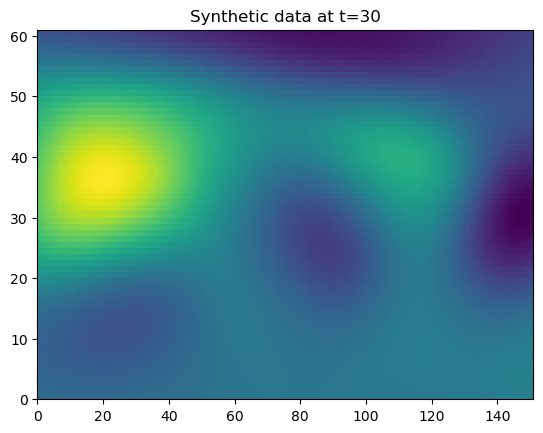

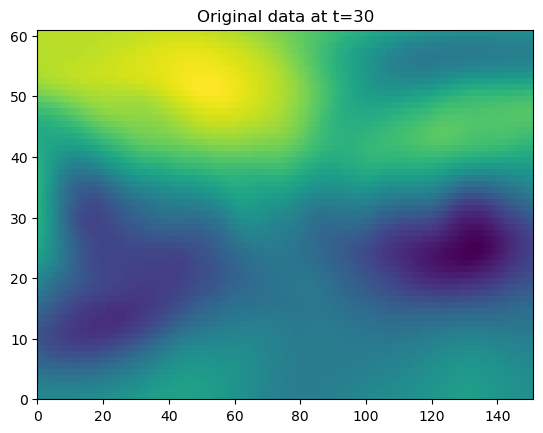

In [55]:
## Another sanity check: plot one example of synthetic data
def convert_from_pcs_to_spatial(a,original_piece_of_data):
    # print(original_piece_of_data)
    original_piece_of_data.data = pca_obj.inverse_transform(a)
    # print(original_piece_of_data)
    return original_piece_of_data.unstack('flat')
    
example_synthetic_data = convert_from_pcs_to_spatial(all_synthetic_data[0][3],
                                                    copy.deepcopy(z500_anoms_flattened_training.isel(time=3)))
plt.pcolormesh(example_synthetic_data)
plt.title('Synthetic data at t=30')
plt.show()

plt.pcolormesh(z500_anoms_flattened_training.isel(time=3).unstack('flat'))
plt.title('Original data at t=30')
plt.show()

In [56]:
classifiability_synthetic = []
for k in range(2,11):
    print(k)
    classifiability_synthetic_temp = []
    for s in range(len(all_synthetic_data)):
        ## Compute classifiability and find the best clustering
        similarity_temp, classifiability_temp, ref_centroids_temp, seed_ref_temp = compute_classifiability(
                               all_synthetic_data[s],
                               k=k,
                               n_init=n_init,
                               pca_obj=pca_obj,
                               n_processes_multiprocessing=n_processes_multiprocessing)
        classifiability_synthetic_temp.append(classifiability_temp)
    classifiability_synthetic.append(classifiability_synthetic_temp)

2
3
4
5
6
7
8
9
10


In [57]:
classifiability_synthetic = np.array(classifiability_synthetic)
lower_bound_synth_class = classifiability_synthetic.min(axis=1)
upper_bound_synth_class = classifiability_synthetic.max(axis=1)

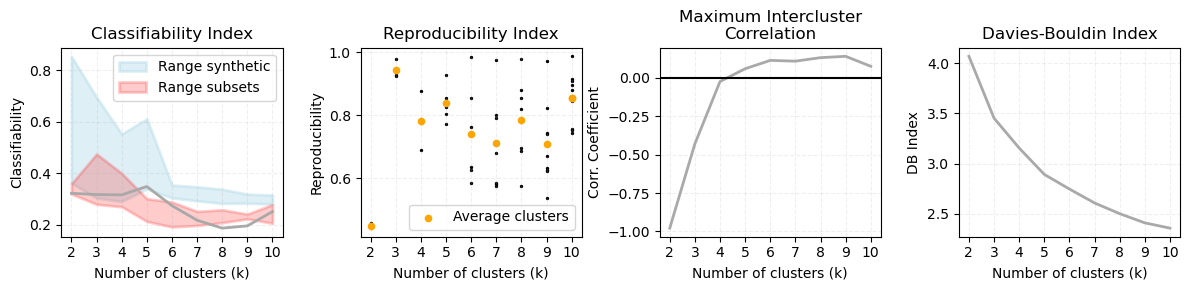

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))

axes[0].fill_between(np.arange(2,11),lower_bound_synth_class, upper_bound_synth_class,
                     color='lightblue',lw=2,alpha=0.4,label='Range synthetic')
axes[0].fill_between(np.arange(2,11),lower_bound_subsets_class,upper_bound_subsets_class,
                     color='red',lw=2,alpha=0.2,label='Range subsets')
axes[0].plot(np.arange(2,11),dic_results_best_k['classifiability'],color='darkgray',lw=2)
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_title('Classifiability Index')
axes[0].set_ylabel('Classifiability')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')
axes[0].legend()

for k in range(2,11):
    axes[1].scatter(np.repeat(k,k),
             dic_results_best_k['reproducibility'][k-2],color='k',s=2)
    axes[1].scatter(k,
             np.mean(dic_results_best_k['reproducibility'][k-2]),
                    color='orange',s=20)
axes[1].scatter(k,
         np.mean(dic_results_best_k['reproducibility'][k-2]),
                color='orange',s=20,label='Average clusters')
    # axes[1].axhline(0,color='k')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Reproducibility')
axes[1].set_title('Reproducibility Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')
axes[1].legend()

axes[2].plot(np.arange(2,11),dic_results_best_k['max_intercluster_corr'],color='darkgray',lw=2)
axes[2].axhline(0,color='k')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Corr. Coefficient')
axes[2].set_title('Maximum Intercluster\nCorrelation')
axes[2].set_xticks(np.arange(2,11))
axes[2].grid(alpha=0.2,ls='--')

axes[3].plot(np.arange(2,11),dic_results_best_k['db_index'],color='darkgray',lw=2)
axes[3].set_xlabel('Number of clusters (k)')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_ylabel('DB Index')
axes[3].set_xticks(np.arange(2,11))
axes[3].grid(alpha=0.2,ls='--')

plt.tight_layout()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

In [59]:
np.save('Results/Control_v0_dic_results_best_k.npy',dic_results_best_k)
np.save('Results/Control_v0_classifiability_synthetic.npy',classifiability_synthetic)

## 9. Compute WRs and do composites

In [100]:
k = 6
# random_seed = dic_results_best_k['seed_ref_centroids'][k-2]
random_seed = 0

In [101]:
# train kmeans
k_means = KMeans(n_clusters=k,
                 init='k-means++',
                 # verbose=1,
                 random_state=random_seed,
                 n_init=100)
k_means.fit(z500_anoms_transformed)
clusters_centers = k_means.cluster_centers_
labels = k_means.labels_

In [102]:
# with open('../Data_v5/k_means_model_era5_v5.pkl','wb') as f:
#     pickle.dump(k_means,f)

In [103]:
cluster_centers = np.vstack([clusters_centers,np.zeros(12)])
distances = euclidean_distances(cluster_centers, z500_anoms_transformed)
new_labels = distances.argmin(axis=0)
df_labels = pd.DataFrame(new_labels,index=anoms_standardized.time)

In [104]:
df_labels.columns=['WR']

In [105]:
df_labels['distances'] = distances.min(axis=0)

In [106]:
def get_average_fields_for_centroids(dataarray,labels):
    wrs = np.unique(labels['WR'])
    avgs = []
    for wr in wrs:
        df_wr = labels[labels['WR']==wr]
        arr_selection = dataarray.sel(time=df_wr.index)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return xr.concat(avgs,dim='WR')

In [107]:
composites = get_average_fields_for_centroids(anoms_standardized,df_labels)

In [108]:
def plot_multiple_maps(da,freqs_labels,regioncoords,names = None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da.WR)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(da.WR.values)-1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-2
        maxi=2
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anomalies.values, 
                           levels=bounds, vmin=mini, vmax=maxi,
                            cmap='coolwarm', transform=ccrs.PlateCarree(),extend='both')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.3, -0.05, 0.4, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if path_save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=100)
        plt.close('all')

In [109]:
frequencies_percent = df_labels['WR'].value_counts(normalize=True) * 100
frequencies_percent = frequencies_percent.sort_index().values
region = [180, 330, 20, 80]

In [110]:
plot_multiple_maps(composites,frequencies_percent,
                   region,names=None, path_save=f'Composites_ControlExp{k}.png')

In [111]:
filename = f'/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/KMeans_ERA5_v20250117_k{k}.mdl'
joblib.dump(k_means,filename)

filename = f'/glade/derecho/scratch/jhayron/BAMS_Preprocessing_WRs/KMeans_ERA5_v20250117_k{k}.pkl'
pickle.dump(k_means, open(filename, 'wb'))

## more Trash (loose code but maybe useful)

In [444]:
### Compute classifiability for the synthetic data
for k in range(2,11):
    n_init = 50 # Number of initializations
    # k=5 #number of clusters
    data4clustering = copy.deepcopy(all_synthetic_data[2])
    params = [(data4clustering, seed_i,k) for seed_i in range(n_init)]
    
    # Create a pool of workers and run KMeans in parallel
    with Pool(processes=50) as pool:
        results_kmeans = pool.map(run_kmeans, params)
    
    ## compute classifiability according to L23 and MV95
    ## (https://journals.ametsoc.org/view/journals/clim/36/20/JCLI-D-23-0214.1.xml#bib39)
    ## 
    
    centroids_inits = []
    for init in range(n_init):
        centroids_inits.append(results_kmeans[init]['cluster_centers'])
    centroids_inits = np.array(centroids_inits)
    
    min_corrs = []
    for init0 in range(n_init):
        min_corrs_temp = []
        for init1 in range(n_init):
            if init0==init1:
                continue
            else:
                # corr_matrix = np.corrcoef(centroids_inits[init0],centroids_inits[init1])[:k,-k:]
                corr_matrix = np.corrcoef(pca_obj.inverse_transform(centroids_inits[init0]),
                                          pca_obj.inverse_transform(centroids_inits[init1]))[:k,-k:]
                cost_matrix = -corr_matrix
                row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
                matched_clusters = list(zip(row_ind, col_ind))
                matched_correlations = corr_matrix[row_ind, col_ind]
                # matched_correlations = corr_matrix.max(axis=0)
                min_corr = np.min(matched_correlations)
                min_corrs_temp.append(min_corr)
    
        min_corrs.append(min_corrs_temp)
    
    min_corrs = np.array(min_corrs)
    print(k,np.mean(min_corrs))

2 0.5214567216139047
3 0.40788267222578534
4 0.3252266584825452
5 0.3350696216147125
6 0.3770727325987714
7 0.4871788729196239
8 0.32666808486373605
9 0.3040100319994152
10 0.2975381512792231


In [42]:
# Compute reproducibility
data4clustering = copy.deepcopy(copy.deepcopy(z500_anoms_transformed))
## Draw 100 random half-length subsamples from the atmospheric data
n_subsets = 100
reproducibility_subsets = []
classifiability_subsets = []
for seed_temp in range(n_subsets):
    print(seed_temp)
    np.random.seed(seed_temp)
    # Select half of the data randomly
    random_indices = np.random.choice(np.arange(len(data4clustering)),size=int(len(data4clustering)/2),replace=False)
    data_subset_temp = data4clustering[random_indices]
    ## Compute similarity on the subset to extract the reference/best clustering
    similarity_temp_subset, classifiability_temp_subset, \
        ref_centroids_temp_subset, seed_ref_temp_subset = compute_classifiability(
                           data_subset_temp,
                           k=k,
                           n_init=50,
                           pca_obj=pca_obj,
                           n_processes_multiprocessing=50)
    ## Correlation matrix between the clusters of  subset and the full set
    corr_matrix = np.corrcoef(pca_obj.inverse_transform(ref_centroids_temp),
                              pca_obj.inverse_transform(ref_centroids_temp_subset))[:k,-k:]
    cost_matrix = -corr_matrix
    ## This line assigns each cluster from group 1 to the most similar cluster from group zero
    ## solving the assignment problem using the Jonker-Volgenant algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
    matched_clusters = list(zip(row_ind, col_ind))
    matched_correlations = corr_matrix[row_ind, col_ind]
    reproducibility_subsets.append(matched_correlations)
    classifiability_subsets.append(classifiability_temp_subset)


0



KeyboardInterrupt



In [40]:
row_ind

array([0, 1, 2, 3, 4])

In [44]:
reproducibility = np.array(reproducibility)


In [46]:
reproducibility.mean(axis=0)

array([0.85058946, 0.89184675, 0.91872801, 0.92022852, 0.95897166])

In [48]:
classifiability_temp_subset

0.28783317463241415

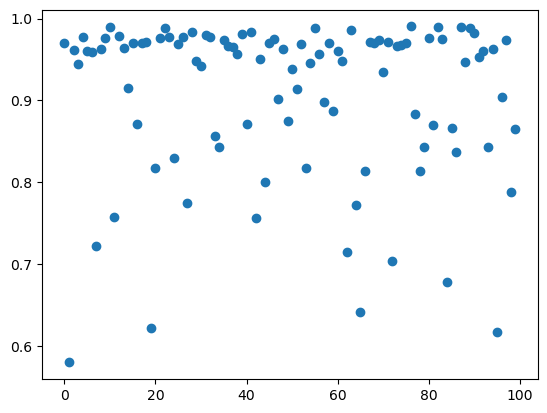

In [39]:
plt.scatter(np.arange(len(reproducibility)),reproducibility)

In [31]:
matched_correlations

array([0.98120346, 0.94530516, 0.9620211 , 0.99176707, 0.96958771])

In [517]:
# for k in range(2,11):
for k in [5]:
    n_init = 50 # Number of initializations
    # k=5 #number of clusters
    data4clustering = copy.deepcopy(z500_anoms_transformed)#[14610:])
    params = [(data4clustering, seed_i,k) for seed_i in range(n_init)]
    
    # Create a pool of workers and run KMeans in parallel
    with Pool(processes=50) as pool:
        results_kmeans = pool.map(run_kmeans, params)
    
    ## compute classifiability according to L23 and MV95
    ## (https://journals.ametsoc.org/view/journals/clim/36/20/JCLI-D-23-0214.1.xml#bib39)
    ## 
    
    centroids_inits = []
    for init in range(n_init):
        centroids_inits.append(results_kmeans[init]['cluster_centers'])
    centroids_inits = np.array(centroids_inits)
    
    min_corrs = []
    for init0 in range(n_init):
        min_corrs_temp = []
        for init1 in range(n_init):
            if init0==init1:
                continue
            else:
                # corr_matrix = np.corrcoef(centroids_inits[init0],centroids_inits[init1])[:k,-k:]
                corr_matrix = np.corrcoef(pca_obj.inverse_transform(centroids_inits[init0]),
                                          pca_obj.inverse_transform(centroids_inits[init1]))[:k,-k:]
                cost_matrix = -corr_matrix
                ## This line assigns each cluster from group 1 to the most similar cluster from group zero
                ## solving the assignment problem using the Jonker-Volgenant algorithm
                row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
                matched_clusters = list(zip(row_ind, col_ind))
                matched_correlations = corr_matrix[row_ind, col_ind]
                # matched_correlations = corr_matrix.max(axis=0)
                min_corr = np.min(matched_correlations)
                min_corrs_temp.append(min_corr)
    
        min_corrs.append(min_corrs_temp)
    
    min_corrs = np.array(min_corrs) ## This is the similarity
    print('k, classifiability, reproducibility')
    print(k,np.mean(min_corrs))

k, classifiability, reproducibility
5 0.37810694035242054


partition 0


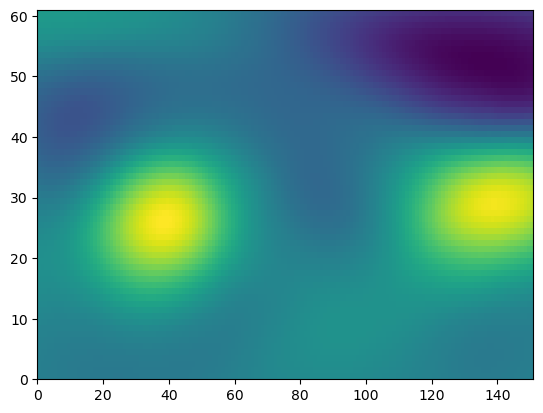

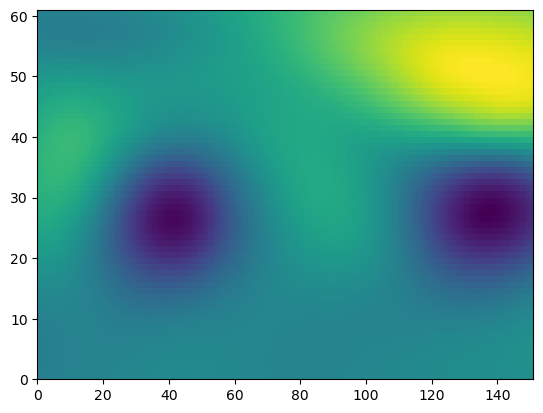

partition 1


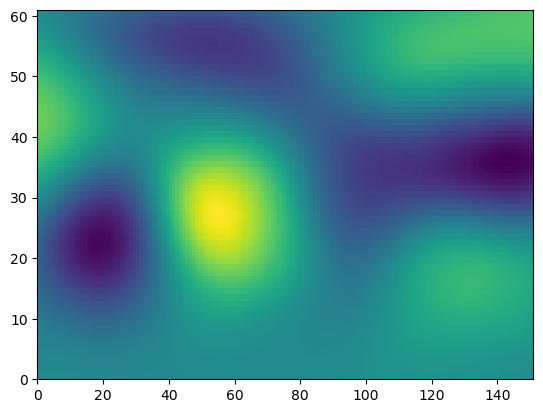

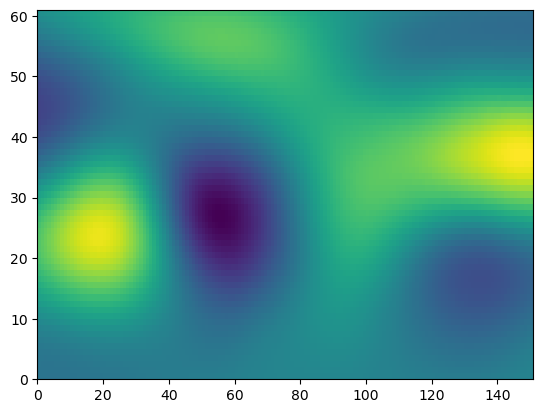

In [481]:
## Check how different is the clustering for each partition
def convert_from_pcs_to_spatial(a,original_piece_of_data):
    # print(original_piece_of_data)
    original_piece_of_data.data = pca_obj.inverse_transform(a)
    # print(original_piece_of_data)
    return original_piece_of_data.unstack('flat')

print('partition 0')
for ktemp in range(k):
    centroid_example = convert_from_pcs_to_spatial(centroids_inits[0][ktemp],
                               z500_anoms_flattened_training.isel(time=0))
    plt.pcolormesh(centroid_example)
    plt.show()

print('partition 1')
for ktemp in range(k):
    centroid_example = convert_from_pcs_to_spatial(centroids_inits[1][ktemp],
                               z500_anoms_flattened_training.isel(time=0))
    plt.pcolormesh(centroid_example)
    plt.show()

In [529]:
## Compute reproducibility:

# 1. Choose the reference partition (with the maximum average similarity value)
pos_reference_partition = min_corrs.mean(axis=1).argmax()
ref_centroids = centroids_inits[pos_reference_partition]

In [548]:
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=500, random_state=0)
kmeans.fit(X_subset_temp)
dic_results_temp = {
                    "inertia": kmeans.inertia_,
                    "cluster_centers": kmeans.cluster_centers_,
                    "labels": kmeans.labels_
                    }

In [551]:
dic_results_temp

{'inertia': 154242.429503107,
 'cluster_centers': array([[ 0.93054066,  0.048824  , -0.31884605, -0.41767303,  0.16710637,
         -0.61178476,  0.02584839,  0.46553765, -0.01964287, -0.63282945,
          0.11101904,  0.2027982 ],
        [ 0.30372665, -0.08003473, -0.31763899,  0.60580789,  0.42467469,
          0.71027123, -0.07167514, -0.43661274, -0.30648718, -0.00343129,
         -0.31845739, -0.30258708],
        [-0.5704578 , -0.18437418,  0.5891751 ,  0.10922371, -0.2212097 ,
         -0.39623868, -0.45871792, -0.42236688, -0.18594197, -0.48678001,
          0.07448601,  0.20030106],
        [-0.40317868, -0.18543473, -0.63098002, -0.23483984, -0.45552781,
          0.0972039 , -0.14269435,  0.34260352,  0.09748228,  0.67452604,
          0.42928616, -0.05756573],
        [-0.0996934 ,  0.51858644,  0.8791943 , -0.20058729,  0.16449501,
          0.15854659,  0.90861365,  0.17634292,  0.56710195,  0.43036483,
         -0.37367014, -0.01186976]]),
 'labels': array([3, 3, 4, ..

In [343]:
from scipy.stats import multivariate_normal
np.random.seed(0)
X = copy.deepcopy(z500_anoms_transformed)

# Assume X has shape (n_times, 12)
# n_times: number of time steps, 12: number of PCs

# Function to compute lag-0 covariance (C0)
def compute_covariance(data):
    """
    Computes the covariance matrix (C0) of the given data.
    data: numpy array of shape (n_times, num_pcs).
    """
    return np.cov(data, rowvar=False)  # Covariance along the PCs (columns)

# Function to compute lag-1 covariance (C1)
def compute_lagged_covariance(data):
    """
    Computes the lag-1 covariance matrix (C1) of the given data.
    data: numpy array of shape (n_times, num_pcs).
    """
    data_t = data[:-1, :]  # Time step t
    data_t1 = data[1:, :]  # Time step t+1
    return np.cov(data_t.T, data_t1.T)[:data.shape[1], data.shape[1]:]

In [454]:
# Function to generate a single synthetic time series
def generate_markov_process(A, Q, C0, steps, num_pcs, seed_temp):
    """
    Generate a synthetic time series following a first-order Markov process.
    """
    np.random.seed(seed_temp)
    # Initialize with random values from the stationary distribution
    X = np.random.multivariate_normal(mean=np.zeros(num_pcs), cov=C0)
    time_series = [X]
    
    for _ in range(steps - 1):
        # Generate noise
        noise = np.random.multivariate_normal(mean=np.zeros(num_pcs), cov=Q)
        # Compute next step
        X = np.dot(A, X) + noise  # Shape: (12,)
        time_series.append(X)
    
    return np.array(time_series)  # Shape: (steps, 12)

# Wrapper function for multiprocessing
def generate_one_variation(args):
    """
    Wrapper function to generate a single time series for multiprocessing.
    """
    A, Q, C0, steps, num_pcs, seed_temp = args
    return generate_markov_process(A, Q, C0, steps, num_pcs, seed_temp)

# Multiprocessing function to generate multiple variations
def generate_multiple_variations_multiprocessing(A, Q, C0, steps, num_pcs, n_variations):
    """
    Generate multiple variations using multiprocessing.
    """
    # Create arguments for each process
    args = [(A, Q, C0, steps, num_pcs, seed_temp) for seed_temp in range(n_variations)]
    
    # Use all available CPU cores
    n_cores = 50 ## SPECIFY # OF CORES
    with Pool(n_cores) as pool:
        all_variations = pool.map(generate_one_variation, args)
    
    return np.array(all_variations)  # Shape: (n_variations, steps, num_pcs)

In [455]:
# Step 1: Compute Covariance Matrices
C0 = compute_covariance(X)  # Lag-0 covariance, shape: (12, 12)
C1 = compute_lagged_covariance(X)  # Lag-1 covariance, shape: (12, 12)

# Step 2: Compute Transition Matrix (A). Since X(t+1) = A.X(t) + w(t)), with w being the noise
# The diagonal of A is the lag-1 autocorrelation of each PC (non-noisy component) with itself
A = np.dot(C1, np.linalg.inv(C0))  # Shape: (12, 12)

# Step 3: Compute Noise Covariance (Q).
#each entry  Q{ij}  represents the covariance between the noise components  w_{i,t}  and  w_{j,t} 
#The noise vector drawn from a muktivariate normal distribution with mean zero and covariance Q
Q = C0 - np.dot(A, C1.T)  # Shape: (12, 12)

# Step 4: Generate synthetic data
n_times = len(X)  # Number of time steps per time series
num_pcs = 12    # Number of PCs
n_variations = 100  # Number of random variations
all_synthetic_data = generate_multiple_variations_multiprocessing(A, Q, C0, n_times, num_pcs, n_variations)
print(all_synthetic_data.shape)

(100, 30681, 12)


In [373]:
## Sanity check: The diagonal of A, Q, and C0 with the synthetic data must be similar to those computed
## with the original data

X_synthetic = all_synthetic_data[77]
C0_synthetic = compute_covariance(X_synthetic)  # Lag-0 covariance, shape: (12, 12)
C1_synthetic = compute_lagged_covariance(X_synthetic)  # Lag-1 covariance, shape: (12, 12)
A_synthetic = np.dot(C1_synthetic, np.linalg.inv(C0_synthetic))  # Shape: (12, 12)
Q_synthetic = C0 - np.dot(A_synthetic, C1_synthetic.T)  # Shape: (12, 12)

print('Diagonals: ')
print('A original:',A.diagonal())
print('A synthetic:',A_synthetic.diagonal())
print('Q original:',Q.diagonal())
print('Q synthetic:',Q_synthetic.diagonal())
print('C1 original:',C1.diagonal())
print('C1 synthetic:',C1_synthetic.diagonal())

#Conclusion--courtesy of ChatGPT:
# 	•	Diagonals of  A  look reasonable and very close between the original and synthetic data, 
#indicating that the lag-1 autocorrelations are well preserved.
# 	•	Diagonals of  Q  show an increase in noise variance in the synthetic data, 
#which is typical and not necessarily a problem.
# 	•	Diagonals of  C_1  are slightly different between the original and synthetic data, 
#but these small deviations (e.g., values slightly less than 1) are normal due to the inherent randomness in generating synthetic data. 
#As long as the covariance structure is generally preserved, these small differences are expected.

# Overall, everything looks correct, and the differences you’re seeing are consistent 
#with the nature of synthetic data generation.

Diagonals: 
A original: [0.97044    0.96897114 0.97196416 0.95827374 0.96188247 0.96468824
 0.95725224 0.96054117 0.95841594 0.95833613 0.95299504 0.95388563]
A synthetic: [0.97026887 0.97061463 0.9731813  0.95861111 0.9608147  0.96465355
 0.9594718  0.96284564 0.95825351 0.95847352 0.95212468 0.95447203]
Q original: [0.0532974  0.04997654 0.05319223 0.07303107 0.06762208 0.06766285
 0.07460253 0.06908547 0.07858111 0.07804057 0.08427388 0.08358333]
Q synthetic: [0.00995619 0.06259573 0.01517145 0.02631287 0.08466622 0.06757332
 0.05922253 0.02345863 0.06328932 0.03146639 0.0985762  0.04496263]
C1 original: [0.97044    0.96897114 0.97196416 0.95827374 0.96188247 0.96468824
 0.95725224 0.96054117 0.95841594 0.95833613 0.95299504 0.95388563]
C1 synthetic: [1.01369987 0.95818547 1.00952562 1.00246407 0.94453725 0.9642807
 0.97289376 1.00696109 0.97359071 1.00465232 0.9388728  0.99242314]


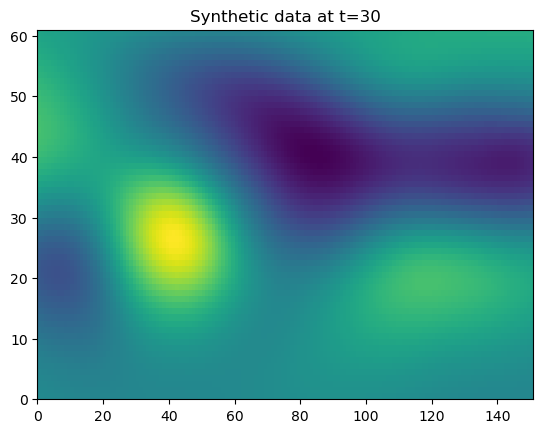

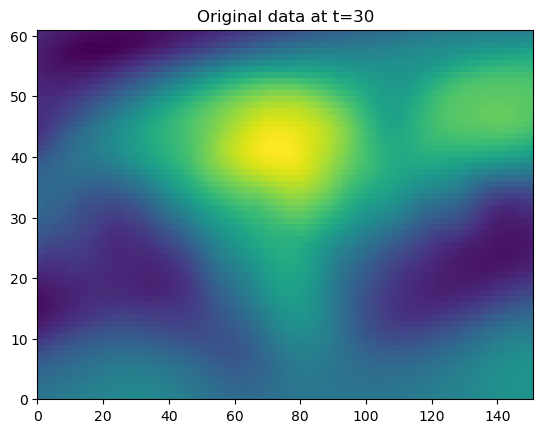

In [464]:
## Another sanity check: plot one example of synthetic data

example_synthetic_data = convert_from_pcs_to_spatial(all_synthetic_data[0][0],
                                                    copy.deepcopy(z500_anoms_flattened_training.isel(time=30)))
plt.pcolormesh(example_synthetic_data)
plt.title('Synthetic data at t=30')
plt.show()

plt.pcolormesh(z500_anoms_flattened_training.isel(time=30).unstack('flat'))
plt.title('Original data at t=30')
plt.show()

In [444]:
### Compute classifiability for the synthetic data
for k in range(2,11):
    n_init = 50 # Number of initializations
    # k=5 #number of clusters
    data4clustering = copy.deepcopy(all_synthetic_data[2])
    params = [(data4clustering, seed_i,k) for seed_i in range(n_init)]
    
    # Create a pool of workers and run KMeans in parallel
    with Pool(processes=50) as pool:
        results_kmeans = pool.map(run_kmeans, params)
    
    ## compute classifiability according to L23 and MV95
    ## (https://journals.ametsoc.org/view/journals/clim/36/20/JCLI-D-23-0214.1.xml#bib39)
    ## 
    
    centroids_inits = []
    for init in range(n_init):
        centroids_inits.append(results_kmeans[init]['cluster_centers'])
    centroids_inits = np.array(centroids_inits)
    
    min_corrs = []
    for init0 in range(n_init):
        min_corrs_temp = []
        for init1 in range(n_init):
            if init0==init1:
                continue
            else:
                # corr_matrix = np.corrcoef(centroids_inits[init0],centroids_inits[init1])[:k,-k:]
                corr_matrix = np.corrcoef(pca_obj.inverse_transform(centroids_inits[init0]),
                                          pca_obj.inverse_transform(centroids_inits[init1]))[:k,-k:]
                cost_matrix = -corr_matrix
                row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
                matched_clusters = list(zip(row_ind, col_ind))
                matched_correlations = corr_matrix[row_ind, col_ind]
                # matched_correlations = corr_matrix.max(axis=0)
                min_corr = np.min(matched_correlations)
                min_corrs_temp.append(min_corr)
    
        min_corrs.append(min_corrs_temp)
    
    min_corrs = np.array(min_corrs)
    print(k,np.mean(min_corrs))

2 0.5214567216139047
3 0.40788267222578534
4 0.3252266584825452
5 0.3350696216147125
6 0.3770727325987714
7 0.4871788729196239
8 0.32666808486373605
9 0.3040100319994152
10 0.2975381512792231


In [21]:
seed_ref_temp

15

In [ ]:
        dbi = davies_bouldin_score(datatransformed, labels)
        # s_score = silhouette_score(datatransformed, labels)
        
        dbis.append(dbi)
        # s_scores.append(s_score)
        # Compute the maximum correlation
        correlation_matrix = np.corrcoef(clusters_centers)
        np.fill_diagonal(correlation_matrix, np.nan)
        maxcorr = np.nanmax(correlation_matrix)
        maxcorrs.append(maxcorr)

In [68]:
def compute_wrs(pcs):
    datatransformed = pcs
    ### GET OPTIMAL NUMBER OF CLUSTERS BASED ON INTERCLUSTER CORRELATION ###
    maxcorrs = []
    dbis = []
    # s_scores = []
    
    nclusterslist = np.arange(2,11)
    for inclusters in nclusterslist:
        # train kmeans
        k_means = KMeans(n_clusters=inclusters,
                         init='k-means++',
                         n_init=500,
                         verbose=0,
                         random_state=random_seed)
        k_means.fit(datatransformed)
        clusters_centers = k_means.cluster_centers_
        labels = k_means.labels_
        # Compute the Davies-Bouldin Index
        dbi = davies_bouldin_score(datatransformed, labels)
        # s_score = silhouette_score(datatransformed, labels)
        
        dbis.append(dbi)
        # s_scores.append(s_score)
        # Compute the maximum correlation
        correlation_matrix = np.corrcoef(clusters_centers)
        np.fill_diagonal(correlation_matrix, np.nan)
        maxcorr = np.nanmax(correlation_matrix)
        maxcorrs.append(maxcorr)

    ## Compute K-means with best number of clusters
    maxcorrs_neg = np.array(maxcorrs)
    maxcorrs_neg[maxcorrs_neg>=0] = np.nan
    
    best_n = nclusterslist[np.min([np.argmin(dbis),np.nanargmax(maxcorrs_neg)])]
    
    # train kmeans
    k_means = KMeans(n_clusters=best_n,
                     init='k-means++',
                     verbose=0,
                     random_state=random_seed)
    k_means.fit(datatransformed)
    clusters_centers = k_means.cluster_centers_
    labels = k_means.labels_
    distances = euclidean_distances(clusters_centers, datatransformed)

    # return datatransformed, clusters_centers, labels, distances, dbis, maxcorrs, s_scores, variance_explained
    return clusters_centers, labels, distances, dbis, maxcorrs

In [69]:
clusters_centers, labels, distances, dbis, maxcorrs = compute_wrs(z500_anoms_transformed)

Text(0.5, 1.0, 'DB index')

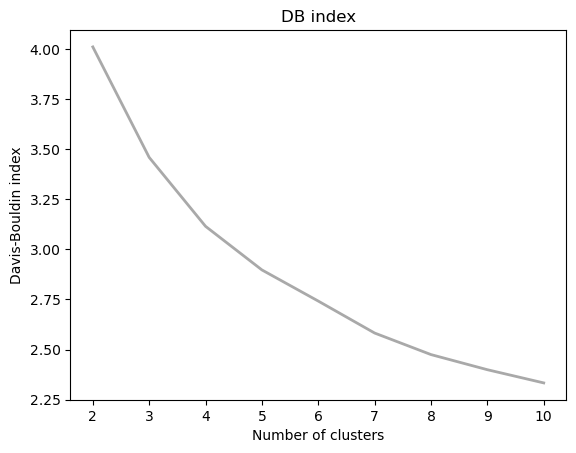

In [70]:
plt.plot(np.arange(2,11),dbis,color='darkgray',lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('Davis-Bouldin index')
plt.title('DB index')
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

Text(0.5, 1.0, 'Intercluster maximum correlation')

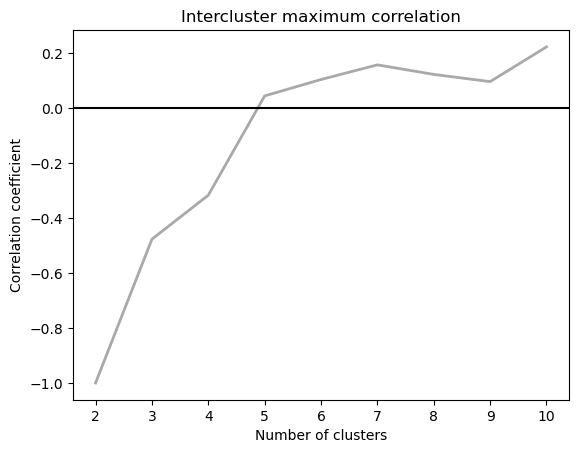

In [71]:
plt.plot(np.arange(2,11),maxcorrs,color='darkgray',lw=2)

plt.axhline(0,color='k')
plt.xlabel('Number of clusters')
plt.ylabel('Correlation coefficient')
plt.title('Intercluster maximum correlation')

In [72]:
print('According to the maximum negative correlation, the maximum number of clusters is 4... However, I did tests changing the random seed, and it varies!!')

According to the maximum negative correlation, the maximum number of clusters is 4... However, I did tests changing the random seed, and it varies!!
